# ВНИМАНИЕ!

Следующее задание крайне рекомендуется выполнять в Google Colab, чтобы обеспечить отсутствие проблем с соединением при скачивании датасета, а также чтобы обеспечить скорость при обучении нейросети. 

In [1]:
import glob
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from tqdm.auto import tqdm

%matplotlib inline
warnings.filterwarnings("ignore")

# Transfer learning

На этом семинаре мы научимся очень быстро обучать нейросеть на сложную задачу классификации изображений, используя очень простой приём, именуемый fine tuning'ом. 

Для начала скачем датасет. На этот раз мы научим нейронку отличать кошечек от собачек.

In [2]:
# !wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip && unzip kagglecatsanddogs_3367a.zip > /dev/null

Удалим несколько битых изображений

In [3]:
# !rm -rf ./PetImages/Cat/666.jpg ./PetImages/Dog/11702.jpg

Датасет разделим средствами pytorch'a на трейн и тест.

In [4]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, Resize, ToTensor

dataset = ImageFolder(
    "./PetImages",
    transform=Compose(
        [
            Resize((224, 224)),
            ToTensor(),
            Normalize((0.5, 0.5, 0.5), (1, 1, 1)),
        ]
    ),
)
train_set, test_set = torch.utils.data.random_split(
    dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
)

Сделаем из скачанных датасетов даталоадеры

In [5]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False)

Посмотрим, как выглядят картинки.

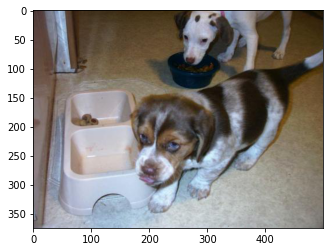

In [6]:
file = np.random.choice(glob.glob("./PetImages/*/*.jpg"))
plt.imshow(plt.imread(file));

## Fine-Tuning

Кошки и собаки это конечно хорошо, вот только обучение модели, которая будет хорошо работать на этом датасете может оказаться очень долгим...

Однако картинки, которые мы сегодня рассмотрим оказываются очень похожими на картинки из огромного датасета ImageNet. Задача, которую мы сегодня рассмотрим, называется Transfer Learning -- в русскоязычной литературе иногда можно встретить термин "обучение с переносом знаний". Знания мы действительно переносим -- от сети, которая хорошо работает на одном датасете (ImageNet) к другим данным (к датасету Cats vs Dogs).

### Загрузим уже обученную сеть

В библиотеке `torchvision` имплементировано не только большое множество моделей (всевозможные ResNet'ы, Inception, VGG, AlexNet, DenseNet, ResNext, WideResNet, MobileNet...), но и загружены чекпоинты обучения этих моделей на ImageNet. Однако для датасета Cats vs Dogs такая штука является роскошью...

In [7]:
from torchvision.models import resnet18

# Загрузить предобученную сеть -- pretrained=True
model = resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
for param in model.parameters():
    param.requires_grad = False

В задаче transfer learning'a мы заменяем последний слой нейросети на линейный с двумя выходами.

In [9]:
model.fc = nn.Linear(512, 2)

Ниже несколько функций, которые мы уже видели в предыдущих семинарах.

In [10]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    criterion,
    return_losses=False,
    device="cuda:0",
):
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])  # .reshape((0, ))
    total_labels = np.array([])  # .reshape((0, ))
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for images, labels in data_loader:
            # Move Batch to GPU
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            # Update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Update descirption for tqdm
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(
                total_predictions, predicted.argmax(1).cpu().detach().numpy()
            )
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def validate(model, data_loader, criterion, device="cuda:0"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(
                total_predictions, predicted.argmax(1).cpu().detach().numpy()
            )
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    return metrics

In [11]:
def fit(
    model,
    epochs,
    train_data_loader,
    validation_data_loader,
    optimizer,
    criterion,
    device="cuda:0",
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(epochs):
        # Train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_data_loader,
            optimizer=optimizer,
            return_losses=True,
            criterion=criterion,
            device=device,
        )
        # Save Train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(
                model=model, data_loader=validation_data_loader, criterion=criterion
            )
        # Save eval losses
        epoch_eval_losses.append(validation_metrics["loss"])

Создайте объект лосса и оптимизатор.

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), 1e-4)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [13]:
fit(model, 5, train_dataloader, test_dataloader, optimizer, criterion, device=device)

Train Epoch: 0


  0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch: 0


  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch: 1


  0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch: 1


  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch: 2


  0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch: 2


  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch: 3


  0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch: 3


  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch: 4


  0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch: 4


  0%|          | 0/20 [00:00<?, ?it/s]

Как видим на одну эпоху обучения уходит порядка двух минут, и уже после одной эпохи получается приемлемое качество. Давайте проинициализируем модель с нуля и попробуем обучить.

In [14]:
model_full = resnet18(pretrained=False)
model_full.fc = nn.Linear(512, 2)
optimizer = torch.optim.Adam(
    model.parameters(), 1e-4
)  # YOUR CODE. It must optimize across all parameters

In [15]:
fit(
    model_full,
    5,
    train_dataloader,
    test_dataloader,
    optimizer,
    criterion,
    device=device,
)

Train Epoch: 0


  0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch: 0


  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch: 1


  0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch: 1


  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch: 2


  0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch: 2


  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch: 3


  0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch: 3


  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch: 4


  0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch: 4


  0%|          | 0/20 [00:00<?, ?it/s]

__Вопрос__. Почему при обучении полной модели получается так, что время на одну эпоху почти такое же?

Рекомендуем подумать на этим вопросом самостоятельно.

Как мы видим, на transfer learning'e нейросеть сходится очень быстро. Значительно быстрее, чем инициализированная с нуля. Можно с уверенностью говорить, что transfer learning -- очень полезная техника.

## Adversarial атаки.

Такая вещь, как атаки на нейросеть крайне важны для учёта при разработке. Существует много методов как их генерации, так и защиты от них. Мы рассмотрим сегодня базовые концепты, чтобы дать понимание происходящего.

Можем назвать adversarial атакой генерацию такого примера, который не отличим глазом от настоящего, но нейросеть будет ОЧЕНЬ уверена в том, что этот пример из другого класса. Сейчас мы попробуем сгенерировать такую собачку, что нейросеть будет уверена, что это котик.

<img src="https://pytorch.org/tutorials/_images/fgsm_panda_image.png">

Сегодня мы рассмотрим пример Fast Gradient Sign Attack (FGSM, почему там буква M в конце -- чёрт его знает...). Идея очень простая. Оказывается, что если мы через обученную нейросеть посчитаем градиент по исходной картинке, посчитаем  его знак и прибавим, умножив на маленькое число, модель подумает, что это картинка другого класса.

Для того, чтобы нам посчитать градиент по входу, нам предстоит "разморозить" все её граиенты.

In [16]:
model.eval()

for param in model.parameters():
    param.requires_grad = True

In [17]:
def fgsm_attack(image, epsilon, data_grad):
    pertrubated_image = image + epsilon * torch.sign(data_grad)
    return pertrubated_image

Выбираем из датасета случайную картинку с кошечкой

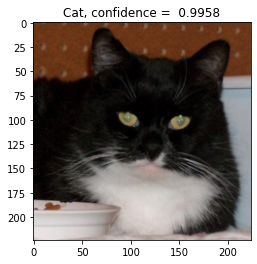

In [18]:
cl = 1
while cl == 1:
    i = np.random.randint(0, len(train_set))
    cl = train_set[i][1]
    image = train_set[i][0]
    image = image.to(device)
    # Разрешим вычисление градиента по картинке
    image.requires_grad = True

    pred = model(image[None])
    predicted_label = pred.argmax(1).item()
    confidence = pred.softmax(1)[0][predicted_label]


# красиво рисуем
if predicted_label == 1:
    plt.title("Dog, confidence = %0.4f" % confidence.item())
else:
    plt.title("Cat, confidence =  %0.4f" % confidence.item())
plt.imshow(image.cpu().detach().numpy().transpose((1, 2, 0)) + 0.5)

Самое интересное начинается тут. Вычислим градиент функции потерь по картинке при помощи вызова .backward().

In [19]:
loss = criterion(pred, torch.tensor(cl).reshape((1,)).to(device))
loss.backward()

Произведём атаку.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


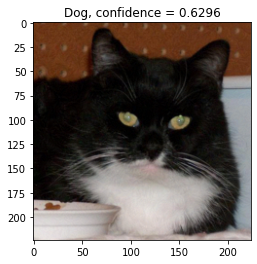

In [20]:
eps = 0.007

attack = fgsm_attack(image, eps, image.grad)
pred = model(attack[None])
predicted_label = pred.argmax(1).item()
confidence = pred.softmax(1)[0][predicted_label]

if predicted_label == 1:
    plt.title("Dog, confidence = %0.4f" % confidence.item())
else:
    plt.title("Cat, confidence =  %0.4f" % confidence.item())
plt.imshow(attack.cpu().detach().numpy().transpose((1, 2, 0)) + 0.5)